<a href="https://colab.research.google.com/github/satvikchekuri/ExplorableMMR/blob/main/ExplorableMMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Few dependencies to be installed everytime we restart this notebook

Run the below two cells at the begnning. Colab might request to restart runtime. 

In [ ]:
#@title
pip install rake_nltk

In [ ]:
#@title
import nltk
nltk.download('punkt')
nltk.download('stopwords')

#**Interactive Text Summarization using Explorable MMR**

## **CS6724: Human AI Interaction**
## *Yuan Li, Daniel Manesh, Syed Muhammad Farhan, and Satvik Chekuri*

# [Maximal Marginal Relevance (MMR)](https://www.cs.cmu.edu/~jgc/publication/The_Use_MMR_Diversity_Based_LTMIR_1998.pdf)
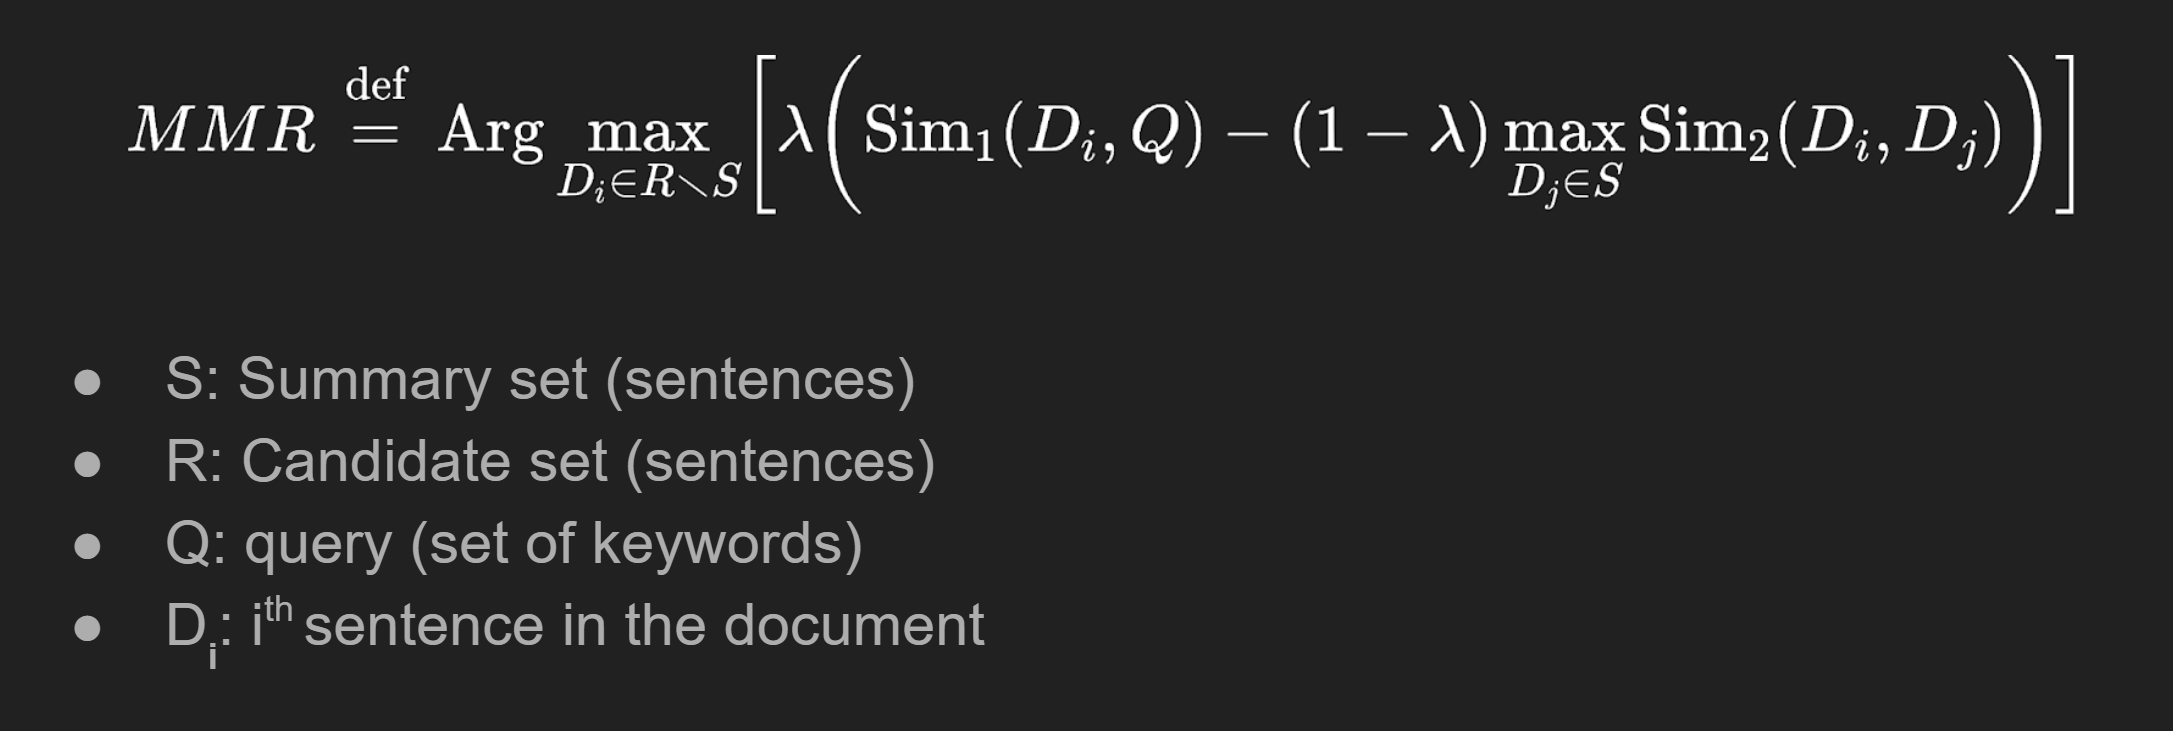


Importing python libraries that are used in this work

In [3]:
#@title
import nltk
import os
import math
import string
import re
import json
from rake_nltk import Metric, Rake
from nltk.corpus import stopwords
from ipywidgets import widgets, interact
from IPython.display import display

### **Enter Input File Path below**

We are using a NYT news article related to COVID vaccine booster shot. [link](https://drive.google.com/file/d/1Flx_Mh-Vq-ZSZxIue-uNPFVo4XWukOdM/view?usp=sharing)

Dataset related to news articles for further evaluation, can be found [here](https://huggingface.co/datasets/viewer/?dataset=cnn_dailymail&config=3.0.0).

In [4]:
input_file_path = '/content/drive/MyDrive/Colab Notebooks/COVIDVaccine_article.txt'

## **Below are functions that perform computations for the individual parts of the MMR method**

### Function to return lines to calculate the overall length and for input to RAKE

In [6]:
#@title
def returnLines(file_name):

    # read file from provided folder path

    f = open(file_name,'r')
    text_0 = f.read()
    # extract content in TEXT tag and remove tags
    #-------------commented --------------
    # text_1 = re.search(r"<TEXT>.*</TEXT>",text_0, re.DOTALL)
    # text_1 = re.sub("<TEXT>\n","",text_1.group(0))
    # text_1 = re.sub("\n</TEXT>","",text_1)

    # replace all types of quotations by normal quotes
    text_1 = re.sub("\n"," ",text_0)

    text_1 = re.sub("\"","\"",text_1)
    text_1 = re.sub("''","\"",text_1)
    text_1 = re.sub("``","\"",text_1)

    text_1 = re.sub(" +"," ",text_1)

    # segment data into a list of sentences
    sentence_token = nltk.data.load('tokenizers/punkt/english.pickle')
    lines = sentence_token.tokenize(text_1.strip())


    return lines

### KeyWord Extraction using RAKE

In [8]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to retrieve the KeyWords using RAKE and it's frequency
# Parameters	: sentences
# Return 		: Kewords, Frequency
#---------------------------------------------------------------------------------
def rakeQuery(lines):
    linestring = " "
    for line in lines:
        linestring = linestring + " " + line + " "
    text = linestring
    r = Rake(ranking_metric=Metric.WORD_FREQUENCY)
    r.extract_keywords_from_text(text)
    # Rp = r.get_ranked_phrases_with_scores()
    Rp = r.get_word_frequency_distribution()
    return Rp

### Sentence class to store setences from the individual files in the document cluster.



In [16]:
#@title
#----------------------------------------------------------------------------------
# Description:	Sentence class to store setences from the individual files in the
#				document cluster.
#----------------------------------------------------------------------------------

from nltk.corpus import stopwords

class sentence(object):

	#------------------------------------------------------------------------------
	# Description	: Constructor to initialize the setence object
	# Parameters  	: docName, name of the document/file
	#				  preproWords, words of the file after the stemming process
	#				  originalWords, actual words before stemming
	# Return 		: None
	#------------------------------------------------------------------------------
	def __init__(self, docName, preproWords, originalWords):
		self.docName = docName
		self.preproWords = preproWords
		self.wordFrequencies = self.sentenceWordFreq()
		self.originalWords = originalWords

	#------------------------------------------------------------------------------
	# Description	: Function to return the name of the document
	# Parameters	: None
	# Return 		: name of the document
	#------------------------------------------------------------------------------
	def getDocName(self):
		return self.docName
	
	#------------------------------------------------------------------------------
	# Description	: Function to return the stemmed words
	# Parameters	: None
	# Return 		: stemmed words of the sentence
	#------------------------------------------------------------------------------
	def getPreProWords(self):
		return self.preproWords
	
	#------------------------------------------------------------------------------
	# Description	: Function to return the original words of the sentence before
	#				  stemming
	# Parameters	: None
	# Return 		: pre-stemmed words
	#------------------------------------------------------------------------------
	def getOriginalWords(self):
		return self.originalWords

	#------------------------------------------------------------------------------
	# Description	: Function to return a dictonary of the word frequencies for
	#				  the particular sentence object
	# Parameters	: None
	# Return 		: dictionar of word frequencies
	#------------------------------------------------------------------------------
	def getWordFreq(self):
		return self.wordFrequencies	
	
	#------------------------------------------------------------------------------
	# Description	: Function to create a dictonary of word frequencies for the
	#				  sentence object
	# Parameters	: None
	# Return 		: dictionar of word frequencies
	#------------------------------------------------------------------------------
	def sentenceWordFreq(self):
		wordFreq = {}
		for word in self.preproWords:
			if word not in wordFreq.keys():
				wordFreq[word] = 1
			else:
				# if word in stopwords.words('english'):
				# 	wordFreq[word] = 1
				# else:			
				wordFreq[word] = wordFreq[word] + 1
		return wordFreq

### Function to preprocess the files in the document cluster before passing them into the MMR summarizer system. Here the sentences of the document cluster are modelled as sentences after extracting from the files in the folder path.

In [14]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to preprocess the files in the document cluster before
#				  passing them into the MMR summarizer system. Here the sentences
#				  of the document cluster are modelled as sentences after extracting
#				  from the files in the folder path. 
# Parameters	: file_name, name of the file in the document cluster
# Return 		: list of sentence object
#---------------------------------------------------------------------------------
def processFile(file_name):

    # read file from provided folder path
    f = open(file_name,'r')
    text_0 = f.read()

    # replace all types of quotations by normal quotes
    text_1 = re.sub("\n"," ",text_0)

    text_1 = re.sub("\"","\"",text_1)
    text_1 = re.sub("''","\"",text_1)
    text_1 = re.sub("``","\"",text_1)

    text_1 = re.sub(" +"," ",text_1)

    # segment data into a list of sentences
    sentence_token = nltk.data.load('tokenizers/punkt/english.pickle')
    lines = sentence_token.tokenize(text_1.strip())


    # setting the stemmer
    sentences = []
    porter = nltk.PorterStemmer()

    # modelling each sentence in file as sentence object
    for line in lines:

        # original words of the sentence before stemming
        originalWords = line[:]
        line = line.strip().lower()

        # word tokenization
        sent = nltk.word_tokenize(line)

        # stemming words
        stemmedSent = [porter.stem(word) for word in sent]
        stemmedSent = list(filter(lambda x: x!='.'and x!='`'and x!=','and x!='?'and x!="'"
            and x!='!' and x!='''"''' and x!="''" and x!="'s", stemmedSent))
        # list of sentence objects

        if stemmedSent != []:
            sentences.append(sentence(file_name, stemmedSent, originalWords))

    return sentences

### Function to find the term frequencies of the words in the sentences present in the provided document cluster

In [18]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to find the term frequencies of the words in the
#				  sentences present in the provided document cluster
# Parameters	: sentences, sentences of the document cluster
# Return 		: dictonary of word, term frequency score
#---------------------------------------------------------------------------------
def TFs(sentences):
    # initialize tfs dictonary
    tfs = {}

    # for every sentence in document cluster
    for sent in sentences:
        # retrieve word frequencies from sentence object
        wordFreqs = sent.getWordFreq()

        # for every word
        for word in wordFreqs.keys():
            # if word already present in the dictonary
            if tfs.get(word, 0) != 0:
                tfs[word] = tfs[word] + wordFreqs[word]
            # else if word is being added for the first time
            else:
                tfs[word] = wordFreqs[word]
    return tfs

### Function to find the inverse document frequencies of the words in the sentences present in the provided document cluster

In [19]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to find the inverse document frequencies of the words in
#				  the sentences present in the provided document cluster 
# Parameters	: sentences, sentences of the document cluster
# Return 		: dictonary of word, inverse document frequency score
#---------------------------------------------------------------------------------
def IDFs(sentences):
    N = len(sentences)
    idf = 0
    idfs = {}
    words = {}
    w2 = []
    # every sentence in our cluster
    for sent in sentences:
        # every word in a sentence
        # wordpre = sent.getPreProWords()
        for word in sent.getPreProWords():
        # for word in wordpre.keys():

            # not to calculate a word's IDF value more than once
            if sent.getWordFreq().get(word, 0) != 0:
                words[word] = words.get(word, 0)+ 1

    # for each word in words
    for word in words:
        n = words[word]
        
        # avoid zero division errors
        try:
            w2.append(n)
            idf = math.log10(float(N)/n)
        except ZeroDivisionError:
            idf = 0
                
        # reset variables
        idfs[word] = idf
    return idfs

### Function to find TF-IDF score of the words in the document cluster

In [20]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to find TF-IDF score of the words in the document cluster
# Parameters	: sentences, sentences of the document cluster
# Return 		: dictonary of word, TF-IDF score
#---------------------------------------------------------------------------------
def TF_IDF(sentences):
    # Method variables
    tfs = TFs(sentences)
    idfs = IDFs(sentences)
    retval = {}

    # for every word
    for word in tfs:
        #calculate every word's tf-idf score
        tf_idfs=  tfs[word] * idfs[word]
        
        # add word and its tf-idf score to dictionary
        if retval.get(tf_idfs, None) == None:
            retval[tf_idfs] = [word]
        else:
            retval[tf_idfs].append(word)

    return retval

### Function to find the sentence similarity for a pair of sentences by calculating cosine similarity

In [21]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to find the sentence similarity for a pair of sentences
#				  by calculating cosine similarity
# Parameters	: sentence1, first sentence
#				  sentence2, second sentence to which first sentence has to be compared
#				  IDF_w, dictinoary of IDF scores of words in the document cluster
# Return 		: cosine similarity score
#---------------------------------------------------------------------------------
def sentenceSim(sentence1, sentence2, IDF_w):
    numerator = 0
    denominator = 0
    denominator1 = 0

    for word in sentence2.getPreProWords():
        numerator+= sentence1.getWordFreq().get(word,0) * sentence2.getWordFreq().get(word,0) *  IDF_w.get(word,0) ** 2

    for word in sentence1.getPreProWords():
        denominator+= ( sentence1.getWordFreq().get(word,0) * IDF_w.get(word,0) ) ** 2

    for word in sentence2.getPreProWords():
        denominator1+= ( sentence2.getWordFreq().get(word,0) * IDF_w.get(word,0) ) ** 2

    # check for divide by zero cases and return back minimal similarity
    try:
        return numerator / (math.sqrt(denominator) * math.sqrt(denominator1))
    except ZeroDivisionError:
        return float("-inf")

## Function to create the summary set of a desired number of words

In [22]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to create the summary set of a desired number of words 
# Parameters	: sentences, sentences of the document cluster
#				  best_sentnece, best sentence in the document cluster
#				  query, reference query for the document cluster
#				  summary_length, desired number of words for the summary
#				  labmta, lambda value of the MMR score calculation formula
#				  IDF, IDF value of words in the document cluster 
# Return 		: name 
#---------------------------------------------------------------------------------
def makeSummary(sentences, best_sentence, query, summary_length, lambta, IDF):	
    summary = [best_sentence]
    # print(best_sentence.getPreProWords())
    # print('summary',summary)
    # sum_len = len(best_sentence.getPreProWords())
    # print('sum_len',sum_len)
    MMRval={}
    dff = pd.DataFrame()
    sentRan = []
    mmrScr = []
    # keeping adding sentences until number of words exceeds summary length
    # while (sum_len < summary_length):
    MMRval={}

    for sent in sentences:
        MMRval[sent] = MMRScore(sent, query, summary, lambta, IDF)
    # maxxer = max(MMRval, key=MMRval.get)
    # summary.append(maxxer)
    # sentences.remove(maxxer)
    # sum_len += len(maxxer.getPreProWords())
    for j in MMRval:
      if len(j.getOriginalWords()) >14:
        sentRan.append(j.getOriginalWords())
        mmrScr.append(MMRval[j])
    dff['sent'] = sentRan
    dff['score'] = mmrScr
    dff = dff.sort_values(by=['score'], ascending = False)
    fig = go.Figure(data=[go.Table(columnwidth = [360,60],header=dict(values=['Sentence', 'MMR Score'],align='left'),
                 cells=dict(values=[dff.sent,dff.score], align='left'))
                     ])
    fig.show()
    return summary

## Function to calculate the MMR score given a sentence, the query and the current best set of sentences

In [23]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to calculate the MMR score given a sentence, the query
#				  and the current best set of sentences
# Parameters	: Si, particular sentence for which the MMR score has to be calculated
#				  query, query sentence for the particualr document cluster
#				  Sj, the best sentences that are already selected
#				  lambta, lambda value in the MMR formula
#				  IDF, IDF value for words in the cluster
# Return 		: name 
#---------------------------------------------------------------------------------
def MMRScore(Si, query, Sj, lambta, IDF):	
    Sim1 = sentenceSim(Si, query, IDF)
    l_expr = lambta * Sim1
    value = [float("-inf")]
    if len(bsent) > 0:
      for sent in Sj:
          Sim2 = sentenceSim(Si, sent, IDF)
          value.append(Sim2)

      r_expr = (1-lambta) * max(value)
      MMRScore = l_expr - r_expr
    else:
      MMRScore = l_expr

    return MMRScore

### Function to prepare User selected summary sentence for MMR scoring function

In [24]:
#@title
#---------------------------------------------------------------------------------
# Description	: Function to prepare User selected summary sentence for MMR scoring function
# Parameters	: sentences
# Return 		: Sentence Object
#---------------------------------------------------------------------------------
def bestSenPrep(senta):
  sentence_token = nltk.data.load('tokenizers/punkt/english.pickle')
  lines = sentence_token.tokenize(senta.strip())
  # setting the stemmer
  sentences = []
  porter = nltk.PorterStemmer()
  # modelling each sentence in file as sentence object
  for line in lines:
  # original words of the sentence before stemming
      originalWords = line[:]
      line = line.strip().lower()
      # word tokenization
      sent = nltk.word_tokenize(line)
      # stemming words
      stemmedSent = [porter.stem(word) for word in sent]
      stemmedSent = list(filter(lambda x: x!='.'and x!='`'and x!=','and x!='?'and x!="'"
          and x!='!' and x!='''"''' and x!="''" and x!="'s", stemmedSent))
      # list of sentence objects
      if stemmedSent != []:
          sentences.append(sentence(input_file_path, stemmedSent, originalWords))
  return sentences

## **Top words recommended by the system to form a Query**

In [9]:
#@title
import plotly.graph_objects as go
import pandas as pd
from nltk.corpus import stopwords

lines=[]

lines = lines + returnLines(input_file_path)
stop_words = set(stopwords.words('english'))
query2 = rakeQuery(lines)
wrd = []
scr = []
for rt in query2:
  if rt.isalnum() and (not rt.isdigit()) and len(rt) > 3 and (not rt in stop_words):
    wrd.append(rt)
    scr.append(query2[rt])
df = pd.DataFrame()
df['word'] = wrd
df['score'] = scr
df = df.sort_values(by=['score'], ascending=False)
fig = go.Figure(data=[go.Table(header=dict(values=['Word', 'Frequency']),
                 cells=dict(values=[df.word,df.score]))
                     ])
fig.show()

## **Input Query**
# Query will be used in MMR Scoring

In [10]:
input_query = input()

moderna


## **Enter the selected summary sentence**

In [11]:
bsent = input()
# Example: Both Moderna and Pfizer require two initial doses, separated by about a month.

Both Moderna and Pfizer require two initial doses, separated by about a month.


## **Select Lambda**
# Higher value gets you more Query relevant sentences
# Lower value get you more diversity based on the sentence selected above
(Unless no sentence is selected above)

In [12]:
#@title
slider = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=1,
    step=0.1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(slider)

FloatSlider(value=0.5, continuous_update=False, max=1.0, min=0.1, readout_format='.1f')

# **Run MMR Ranking**

In [25]:
#@title
#---------------------------------------------------------------------------------
# Description	: Code block that runs individual functions required to compute the MMR Score
# Outputs 		: Table with sentences and their related scores computed by MMR
#---------------------------------------------------------------------------------
sentences = []
lines=[]
queryWords = []

sentences = sentences + processFile(input_file_path)
lines = lines + returnLines(input_file_path)
linestring = " "
for line in lines:
    linestring = linestring + " " + line + " "
sen_len = len(linestring)
# calculate TF, IDF and TF-IDF scores
IDF_w 		= IDFs(sentences)
TF_IDF_w 	= TF_IDF(sentences)

# build query; set the number of words to include in our query
queryWords.append(input_query)
query = sentence("query", queryWords, queryWords)

# pick a sentence that best matches the query
bstsen = 'Both Moderna and Pfizer require two initial doses, separated by about a month.'
if len(bsent) <1:
  best1sentence = bsent
else: 
  best1sentence = bestSenPrep(bsent)[0]
# build summary by adding more relevant sentences
summary = makeSummary(sentences, best1sentence, query, 0.01 * sen_len, slider.value, IDF_w)

**End of the notebook**

This notebook is made public within VT network. 

Please contact satvikchekuri@vt.edu if the notebook is not running as intended. 



